In [2]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import time
import pickle

import sklearn
from sklearn.model_selection import train_test_split
from pygam import GAM, LinearGAM, LogisticGAM, PoissonGAM, InvGaussGAM, s, f, te 
from pygam import intercept
from sklearn.metrics import accuracy_score

import memory_profiler
%load_ext memory_profiler

from pathlib import Path

In [4]:
sklearn.__version__

'1.1.1'

In [5]:
import pygam

pygam.__version__

'0.8.0'

In [3]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [7]:
%load_ext autoreload
%autoreload 2

from pubmed_landscape_src.gam import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
berenslab_data_path = Path("/gpfs01/berens/data/data/pubmed_processed")

In [5]:
plt.style.use("matplotlib_style.txt")

# Neuroscience analysis

## Import

In [13]:
tsne_reparsed=np.load(variables_path / "bert/tsne_reparsed.npy")

In [14]:
#save results
colors_new = np.load(variables_path / "colors_new.npy", allow_pickle = True)

In [15]:
pickle_in = open(variables_path / "colors_new_legend.pkl","rb")
colors_new_legend = pickle.load(pickle_in)

In [16]:
# save
date_year = np.load(variables_path / "date_year_reparsed.npy")

## Labels

In [17]:
# define vocabulary swap
new_colors_legend_swap = {value:key for key, value in colors_new_legend.items()}

In [19]:
labels = np.vectorize(new_colors_legend_swap.get)(colors_new)
labels = np.where(colors_new == 'lightgrey', 'unlabeled', labels)

In [922]:
print('number of nsc papers: ', len(labels[labels == 'neuroscience']))

number of nsc papers:  240135


## Colours based on title keywords

In [172]:
# import clean_df_updated
clean_df_updated_reparsed_filtered = pd.read_pickle(variables_path / "clean_df_updated_reparsed_filtered")

tcmalloc: large alloc 1073741824 bytes == 0xdb0b40000 @ 
tcmalloc: large alloc 1233903616 bytes == 0xe5aab4000 @ 


In [173]:
nsc_titles = clean_df_updated_reparsed_filtered['Title'][colors_new==colors_new_legend['neuroscience']]

In [175]:
nsc_words=['plasticity', 'visual', 'auditory', 'parkinson', 'learning', 
 'memory', 'sleep', 
 'depression', 
 'cognitive', 'olfactory', 'alzheimer', 'social', 
 'pain',
 'attention', 'prefrontal', 'temporal', 'schizophrenia',
 'retina', 'stress', 
 'sensory', 'cerebellar', 'hippocampus', 'motor', 'perception', 
 'age', 
 'behavioral','stroke', 'epilepsy', 'reward', 
 'imaging', 'fear',
 'astrocytes', 'sclerosis',
]

print(len(nsc_words))

nsc_words_min = [' '+x for x in nsc_words]
nsc_words_may = [x.capitalize() for x in nsc_words]

33


In [176]:
best_clusterCols_clean=[
'#FFFF00', '#1CE6FF', '#FF34FF', '#FF4A46', '#008941', '#006FA6', '#A30059', '#7A4900', '#0000A6', '#63FFAC', '#B79762','#004D43',
'#5A0007',  '#1B4400', '#4FC601', '#3B5DFF', '#4A3B53', '#FF2F80','#6B7900', '#00C2A0', '#FFAA92', '#FF90C9','#B903AA', '#D16100',
 '#7B4F4B',  '#0AA6D8','#00846F', '#FFB500', '#A079BF', '#CC0744', '#C2FF99', '#00489C', '#6F0062',
'#0CBD66','#EEC3FF', '#456D75', '#B77B68', '#788D66', '#FAD09F','#BEC459', '#456648', '#0086ED','#886F4C',
    
 '#00A6AA', '#A3C8C9', '#575329', '#00FECF', '#B05B6F',
'#8CD0FF', '#3B9700', '#04F757', '#C8A1A1', '#1E6E00', '#7900D7', '#A77500', '#6367A9', '#A05837', '#6B002C', '#772600', '#D790FF',
'#9B9700', '#549E79', '#FFF69F', '#201625', '#72418F', '#BC23FF', '#99ADC0', '#3A2465', '#922329', '#5B4534', '#FDE8DC', '#404E55',
'#0089A3', '#CB7E98', '#A4E804', '#324E72', '#6A3A4C', '#83AB58', '#001C1E', '#D1F7CE', '#004B28', '#C8D0F6', '#A3A489', '#806C66',
'#222800', '#BF5650', '#E83000', '#66796D', '#DA007C', '#FF1A59', '#8ADBB4', '#1E0200', '#5B4E51', '#C895C5', '#320033', '#FF6832',
'#66E1D3', '#CFCDAC', '#D0AC94', '#7ED379', '#012C58'
]

In [178]:
%%time
nsc_colors_reparsed_legend, nsc_colors_reparsed= automatic_coloring(nsc_titles, nsc_words_may, nsc_words_min, best_clusterCols_clean)

CPU times: user 11.4 s, sys: 88.5 ms, total: 11.5 s
Wall time: 11.5 s


In [179]:
nsc_colors_reparsed.shape

(240135,)

In [371]:
#save results
np.save(variables_path / "nsc_colors_reparsed", nsc_colors_reparsed)

#save results
f = open(variables_path / "nsc_colors_reparsed_legend.pkl","wb")
pickle.dump(nsc_colors_reparsed_legend,f)
f.close()

## kNN overlap for 'neuroscience' and different labels per years

In [21]:
%%time
%memit
embeddings_reparsed_all=np.load(berenslab_data_path / 'embeddings/embeddings_reparsed_all.npy')

peak memory: 1178.04 MiB, increment: -86.51 MiB


tcmalloc: large alloc 127101853696 bytes == 0x412b0000 @ 


CPU times: user 119 ms, sys: 1min 17s, total: 1min 18s
Wall time: 1min 43s


### Calculation

In [ ]:
%%time
X = embeddings_reparsed_all
years = np.arange(1970,2022)
class1 = 'neuroscience'
other_classes = ['psychology', 'neurology', 'pharmacology', 'physiology', 'psychiatry', 'computation', 'biochemistry']


individual_years, individual_knn_overlapp, average_knn_overlap = get_knn_overlap_gam(X, labels, date_year, years, 
                                                                                     class1, other_classes, subset_size=500,
                                                                                     verbose=True)

tcmalloc: large alloc 43768053760 bytes == 0x1de4814000 @ 


year 1970
year 1971
year 1972
year 1973
year 1974
year 1975
year 1976
year 1977
year 1978
year 1979
year 1980


In [40]:
print(individual_years.shape)
print(individual_knn_overlapp.shape)
print(average_knn_overlap.shape)

(26000,)
(26000, 7)
(52, 7)


In [ ]:
np.save(variables_path / 'individual_years_nsc', individual_years)
np.save(variables_path / 'individual_knn_overlapp_nsc', individual_knn_overlapp)
np.save(variables_path / 'average_knn_overlap_nsc', average_knn_overlap)

### Fitting a Generalized Additive Model (GAM)

In [27]:
individual_years = np.load(variables_path / 'individual_years_nsc.npy')
individual_knn_overlapp = np.load(variables_path / 'individual_knn_overlapp_nsc.npy')
average_knn_overlap = np.load(variables_path / 'average_knn_overlap_nsc.npy')

In [29]:
# Filter out -1s (for more explanation see pubmed_landscape_src.gam)
individual_years_clean = individual_years[individual_years != -1]
individual_knn_overlapp_clean = individual_knn_overlapp[individual_years != -1]

In [113]:
%%time

other_classes = ['psychology', 'neurology', 'pharmacology', 'physiology', 'psychiatry', 'computation', 'biochemistry']
gam_plotting_results = pd.DataFrame(index = ['XX', 'pdep', 'confi', 'intercept'])

for i, label in enumerate(other_classes):
    print(label)
    
    gam = train_linear_gam(individual_years_clean, individual_knn_overlapp_clean[:,i]*10, verbose=True)
    
    XX, pdep, confi, intercept = get_plot_gam(gam, 'linear')
    
    gam_plotting_results[label] = [XX, pdep, confi, intercept]
    

  5% (1 of 20) |#                        | Elapsed Time: 0:00:00 ETA:  00:00:00

psychology


100% (20 of 20) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
/tmp/ipykernel_14374/3396477449.py:28: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()
 15% (3 of 20) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:00

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      5.8156
Link Function:                     IdentityLink Log Likelihood:                                -22831.5476
Number of Samples:                        17541 AIC:                                            45676.7264
                                                AICc:                                           45676.7325
                                                GCV:                                                0.7592
                                                Scale:                                              0.7587
                                                Pseudo R-Squared:                                   0.0165
Feature Function                  Lam

100% (20 of 20) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
/tmp/ipykernel_14374/3396477449.py:28: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()
  5% (1 of 20) |#                        | Elapsed Time: 0:00:00 ETA:  00:00:00

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      5.5017
Link Function:                     IdentityLink Log Likelihood:                                -41441.5599
Number of Samples:                        17541 AIC:                                            82896.1232
                                                AICc:                                           82896.1288
                                                GCV:                                                3.7029
                                                Scale:                                              3.7008
                                                Pseudo R-Squared:                                   0.0174
Feature Function                  Lam

100% (20 of 20) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
/tmp/ipykernel_14374/3396477449.py:28: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()
  5% (1 of 20) |#                        | Elapsed Time: 0:00:00 ETA:  00:00:00

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      4.9602
Link Function:                     IdentityLink Log Likelihood:                                -36140.7137
Number of Samples:                        17541 AIC:                                            72293.3478
                                                AICc:                                           72293.3525
                                                GCV:                                                2.5809
                                                Scale:                                              2.5796
                                                Pseudo R-Squared:                                   0.0297
Feature Function                  Lam

100% (20 of 20) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
/tmp/ipykernel_14374/3396477449.py:28: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()
 15% (3 of 20) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:00

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      3.8959
Link Function:                     IdentityLink Log Likelihood:                                -35723.1512
Number of Samples:                        17541 AIC:                                            71456.0942
                                                AICc:                                           71456.0974
                                                GCV:                                                2.5053
                                                Scale:                                              2.5043
                                                Pseudo R-Squared:                                   0.0418
Feature Function                  Lam

100% (20 of 20) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
/tmp/ipykernel_14374/3396477449.py:28: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()
 15% (3 of 20) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:00

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      3.4362
Link Function:                     IdentityLink Log Likelihood:                                -27331.2734
Number of Samples:                        17541 AIC:                                            54671.4192
                                                AICc:                                            54671.422
                                                GCV:                                                1.2842
                                                Scale:                                              1.2838
                                                Pseudo R-Squared:                                   0.0342
Feature Function                  Lam

100% (20 of 20) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
/tmp/ipykernel_14374/3396477449.py:28: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()
 15% (3 of 20) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:00

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      3.8959
Link Function:                     IdentityLink Log Likelihood:                                -28753.0125
Number of Samples:                        17541 AIC:                                            57515.8168
                                                AICc:                                           57515.8201
                                                GCV:                                                0.2269
                                                Scale:                                              0.2268
                                                Pseudo R-Squared:                                   0.0084
Feature Function                  Lam

100% (20 of 20) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      5.4664
Link Function:                     IdentityLink Log Likelihood:                                -23612.2157
Number of Samples:                        17541 AIC:                                            47237.3643
                                                AICc:                                           47237.3698
                                                GCV:                                                0.8539
                                                Scale:                                              0.8534
                                                Pseudo R-Squared:                                   0.0197
Feature Function                  Lam

/tmp/ipykernel_14374/3396477449.py:28: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [ ]:
# save
gam_plotting_results.to_pickle(variables_path / "gam_knn_overlap_plotting_results")

### Plot

In [49]:
# load 
gam_plotting_results=pd.read_pickle(variables_path / "gam_knn_overlap_plotting_results")

In [116]:
gam_plotting_results_T=gam_plotting_results.transpose()
#gam_plotting_results_T

psychology
neurology
pharmacology
physiology
psychiatry
computation
biochemistry


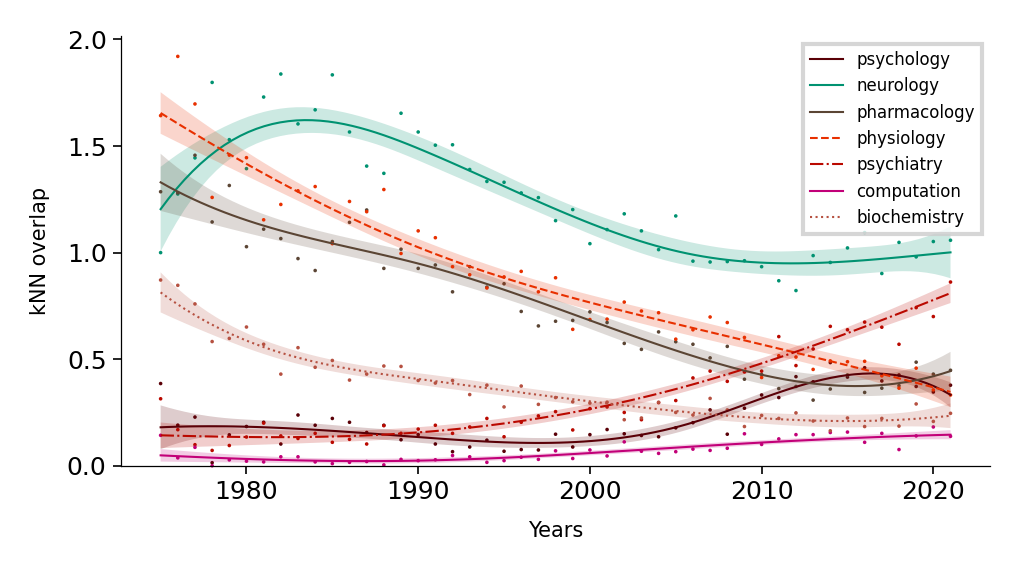

In [111]:
%matplotlib inline
years = np.arange(1970,2022)
other_classes = ['psychology', 'neurology', 'pharmacology', 'physiology', 'psychiatry', 'computation', 'biochemistry']
linestyles = ['-', '-', '-', '--', '-.', '-', ':']
with plt.style.context('matplotlib_style.txt'):
    fig, ax = plt.subplots(figsize=(3.5, 2), dpi=300)
    for i, label in enumerate(other_classes):
        print(label)
        
        linestyle= linestyles[i]
        
        

        ax.plot(gam_plotting_results_T.XX[label][:, 0], gam_plotting_results_T.pdep[label],
                c=colors_new_legend[label], label=label, linestyle=linestyle)
        
        ax.fill_between(gam_plotting_results_T.XX[label][:, 0], 
                        gam_plotting_results_T.confi[label][:,1], 
                        gam_plotting_results_T.confi[label][:,0], 
                        color=colors_new_legend[label], alpha=0.2, edgecolor=None)
        
        ax.scatter(np.unique(individual_years_clean)[average_knn_overlap_corrected[:,i]!=-1],average_knn_overlap_corrected[:,i][average_knn_overlap_corrected[:,i]!=-1]*10, 
                   c=colors_new_legend[label], marker='.', s=3,clip_on=False)
        
    ax.set_ylim(bottom=0)
    ax.legend(loc='upper right', fontsize=4)
    ax.set_xlabel('Years')
    ax.set_ylabel('kNN overlap')

    fig.savefig(figures_path / 'gam_knn_overlapp_all_data_bert_1970.png', facecolor='white')